# Import modules

In [1]:
from Helper_Functions import *
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import contextlib

/Users/samcong/anaconda3/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Define parameters of the robot task

In [3]:
# Body parts analyzed (e.g., arms + head + legs + antenna + feet)
feature = ["bo", "he", "ar", "le", "an"]
feature_num = len(feature)
# Number of options per class (e.g., 6 possible arms and legs for each robot)
class_num = 6
# All potential "feature * class_num" combinations of lables
labels = [f"{f}_{n}" for f in feature for n in range(1, class_num + 1)]
label_num = len(labels)

# Dataset spliting for model training, validation, and testing
split_ratio = (0.8, 0.1, 0.1)
# An integer for reproducibility of data spliting using sklearn.model_selection
random_state = 42 

# Batch size
batch_size = 32

# Setting a learning rate
base_learning_rate = 0.01

# A threshold value to determine which class the 
# predicted probability corresponds to
p_r_threshold = 0.5

# Class weights to account for imbalanced dataset
total_features = (class_num * feature_num)
one_weight = (1 / feature_num) * (total_features / 2.0)
zero_weight = (1 / (total_features - feature_num)) * (total_features / 2.0)
positive_weight_body = 6
positive_weight_other = 7 # higher because category can be missing
positive_weights = [positive_weight_body]*class_num 
positive_weights += [positive_weight_other]*(total_features - class_num) 
positive_weights = tf.constant(positive_weights, dtype=tf.float32)

# Load images

In [4]:
cwd = os.getcwd()
image_array, label_df = images_and_labels(cwd, feature_num,class_num, labels)

In [5]:
# First dimension of image_array represents number of robots
# Second and third dimensions represent image pixel size
image_array.shape 

(1470, 750, 750)

In [6]:
label_df.head()

,bo_1,bo_2,bo_3,bo_4,bo_5,bo_6,he_1,he_2,he_3,he_4,...,le_3,le_4,le_5,le_6,an_1,an_2,an_3,an_4,an_5,an_6
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


# Preprocess data

In [7]:
train_data, val_data, test_data = preprocessing(image_array, label_df, 
                                                split_ratio, random_state,
                                                batch_size)

Diplay the first batch of images alongside their associated labels

2023-12-07 14:27:26.961795: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


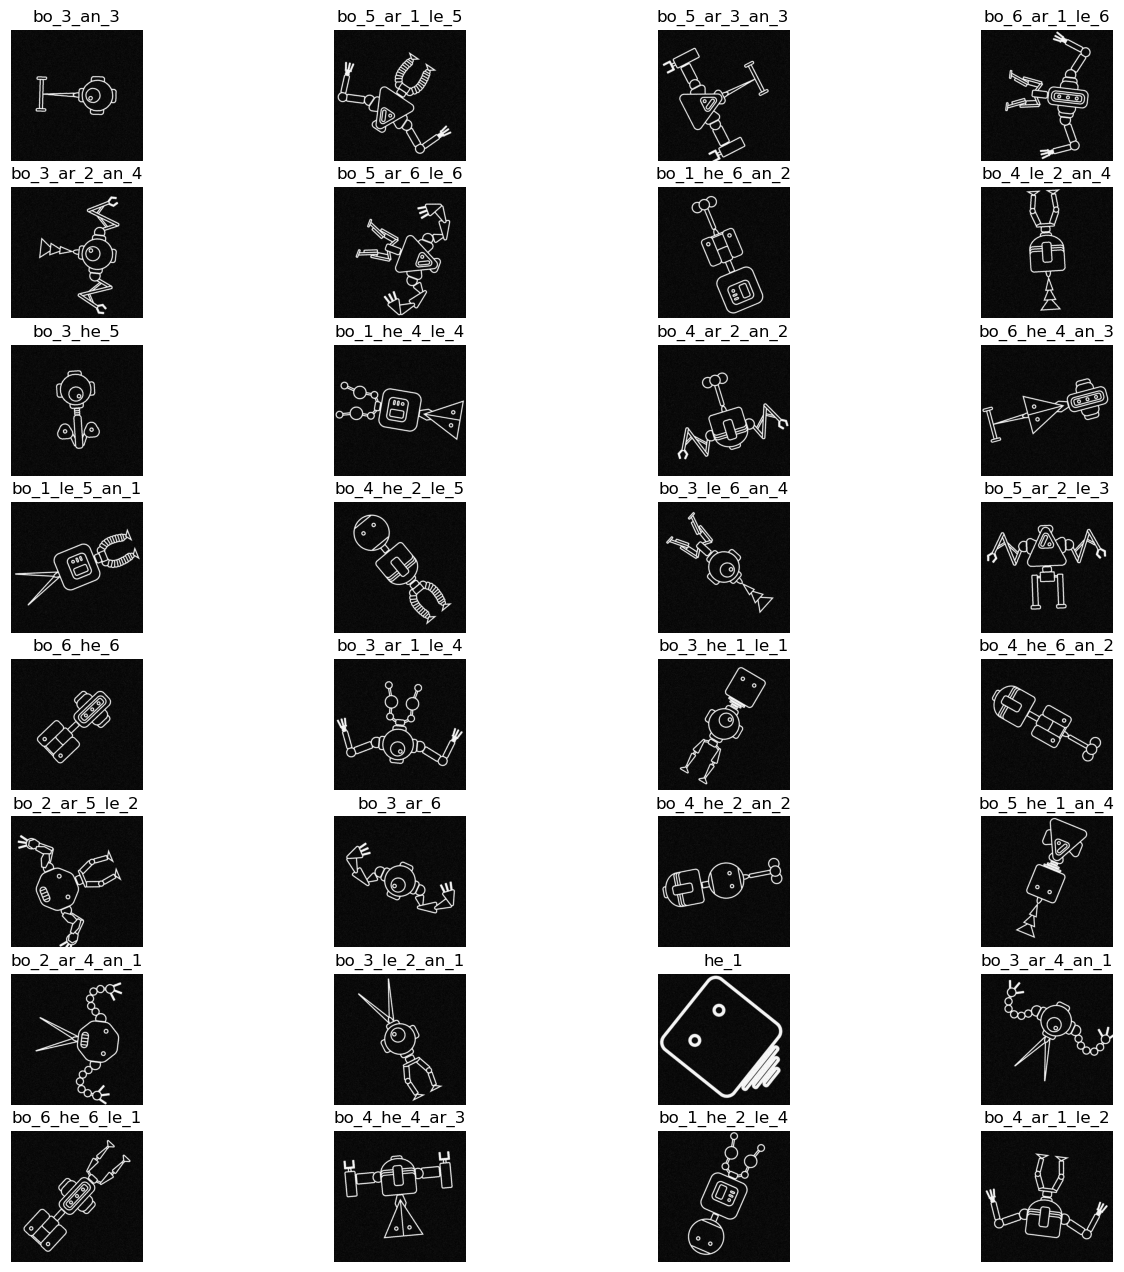

In [8]:
image_batch, label_batch = next(iter(train_data.take(1)))

# Number of images to display from the batch
num_images = len(image_batch)

plt.figure(figsize=(16, 16))
for i in range(num_images):
    plt.subplot(num_images // 4, 4, i + 1)
    # Display the image
    plt.imshow(image_batch[i].numpy().squeeze(), cmap='gray')

    # Associate the image with the label
    feature_vec = label_batch[i].numpy()
    feature_idx = np.where(feature_vec == 1)[0].tolist()
    string = ""
    for i in feature_idx:
        string += (labels[i] + "_")
    plt.title(string[:-1])
    plt.axis("off")

# Build and compile the model

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import Recall, Precision, BinaryAccuracy
from keras.callbacks import EarlyStopping

In [10]:
# Build a simple CNN (using 5*5 filters)
model = Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(750, 750, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),  # Additional Conv layer
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),  # Increased units
    Dropout(0.5),  # Add dropout with 50% probability
    Dense(128, activation='relu'),
    Dropout(0.5),  # Add dropout with 50% probability
    Dense(30, activation='sigmoid')
])

In [11]:
# Compile the CNN model
recall = Recall(thresholds=p_r_threshold)
precision = Precision(thresholds=p_r_threshold)
accuracy = BinaryAccuracy(threshold=p_r_threshold)

model.compile(loss=create_weighted_cross_entropy(positive_weights),
              optimizer=Adam(learning_rate=base_learning_rate),
              metrics=[recall, precision, accuracy])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, verbose=1, mode='min', 
                               restore_best_weights=True)

# Fit, predict, and evaluate the model

In [12]:
model.fit(train_data, epochs=20, 
          validation_data=val_data, callbacks=[early_stopping])

Epoch 1/20
37/37 [==============================] - 389s 10s/step - loss: 1.0969 - recall: 0.1552 - precision: 0.1201 - binary_accuracy: 0.8114 - val_loss: 1.0838 - val_recall: 0.0991 - val_precision: 0.1429 - val_binary_accuracy: 0.8562
Epoch 2/20
37/37 [==============================] - 405s 11s/step - loss: 1.0855 - recall: 0.1298 - precision: 0.1367 - binary_accuracy: 0.8391 - val_loss: 1.0838 - val_recall: 0.0991 - val_precision: 0.1429 - val_binary_accuracy: 0.8562
Epoch 3/20
37/37 [==============================] - 397s 11s/step - loss: 1.0850 - recall: 0.1307 - precision: 0.1384 - binary_accuracy: 0.8398 - val_loss: 1.0838 - val_recall: 0.0991 - val_precision: 0.1429 - val_binary_accuracy: 0.8562
Epoch 4/20
37/37 [==============================] - 383s 10s/step - loss: 1.0845 - recall: 0.1304 - precision: 0.1398 - binary_accuracy: 0.8408 - val_loss: 1.0838 - val_recall: 0.0991 - val_precision: 0.1429 - val_binary_accuracy: 0.8562
Epoch 4: early stopping


Evaluate on validation data

In [14]:
val_loss, val_recall, val_precision, val_accuracy = model.evaluate(val_data)
print(f"Validation data loss: {val_loss}")
print(f"Validation data accuracy: {val_accuracy}")
print(f"Validation data recall: {val_recall}")
print(f"Validation data precision: {val_precision}")

5/5 [==============================] - 8s 1s/step - loss: 1.0838 - recall: 0.0991 - precision: 0.1429 - binary_accuracy: 0.8562
Validation data loss: 1.0837827920913696
Validation data accuracy: 0.8562358021736145
Validation data recall: 0.09905660152435303
Validation data precision: 0.1428571492433548


Evaluate on test data

In [15]:
test_loss, test_recall, test_precision, test_accuracy = model.evaluate(test_data)
print(f"Test data loss: {test_loss}")
print(f"Test data accuracy: {test_accuracy}")
print(f"Test data recall: {test_recall}")
print(f"Test data precision: {test_precision}")

5/5 [==============================] - 8s 1s/step - loss: 1.0812 - recall: 0.1085 - precision: 0.1565 - binary_accuracy: 0.8580
Test data loss: 1.0811529159545898
Test data accuracy: 0.8580498695373535
Test data recall: 0.10849056392908096
Test data precision: 0.15646257996559143


Use this model to predict labels from test_data images

In [16]:
predictions = model.predict(test_data)
binary_prediction = np.where(predictions > 0.5, 1, 0)
binary_prediction

5/5 [==============================] - 7s 1s/step


array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [26]:
_, _, true_labels = data_split(label_df, split_ratio, random_state = random_state)
true_labels

,bo_1,bo_2,bo_3,bo_4,bo_5,bo_6,he_1,he_2,he_3,he_4,...,le_3,le_4,le_5,le_6,an_1,an_2,an_3,an_4,an_5,an_6
464,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
49,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
332,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1114,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
886,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
101,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
743,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1295,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


/Users/samcong/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


InvalidIndexError: (slice(None, None, None), 0)

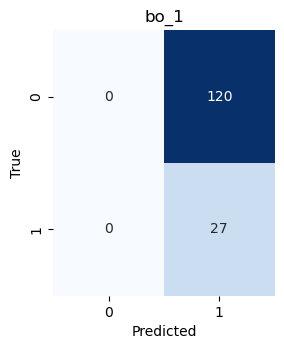

In [27]:
classifi_report, confusion_matrix, roc_auc = test_predict_eval(binary_prediction, 
                                                               true_labels, 
                                                               feature_num, 
                                                               class_num, 
                                                               labels)

print(classifi_report)

/Users/samcong/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


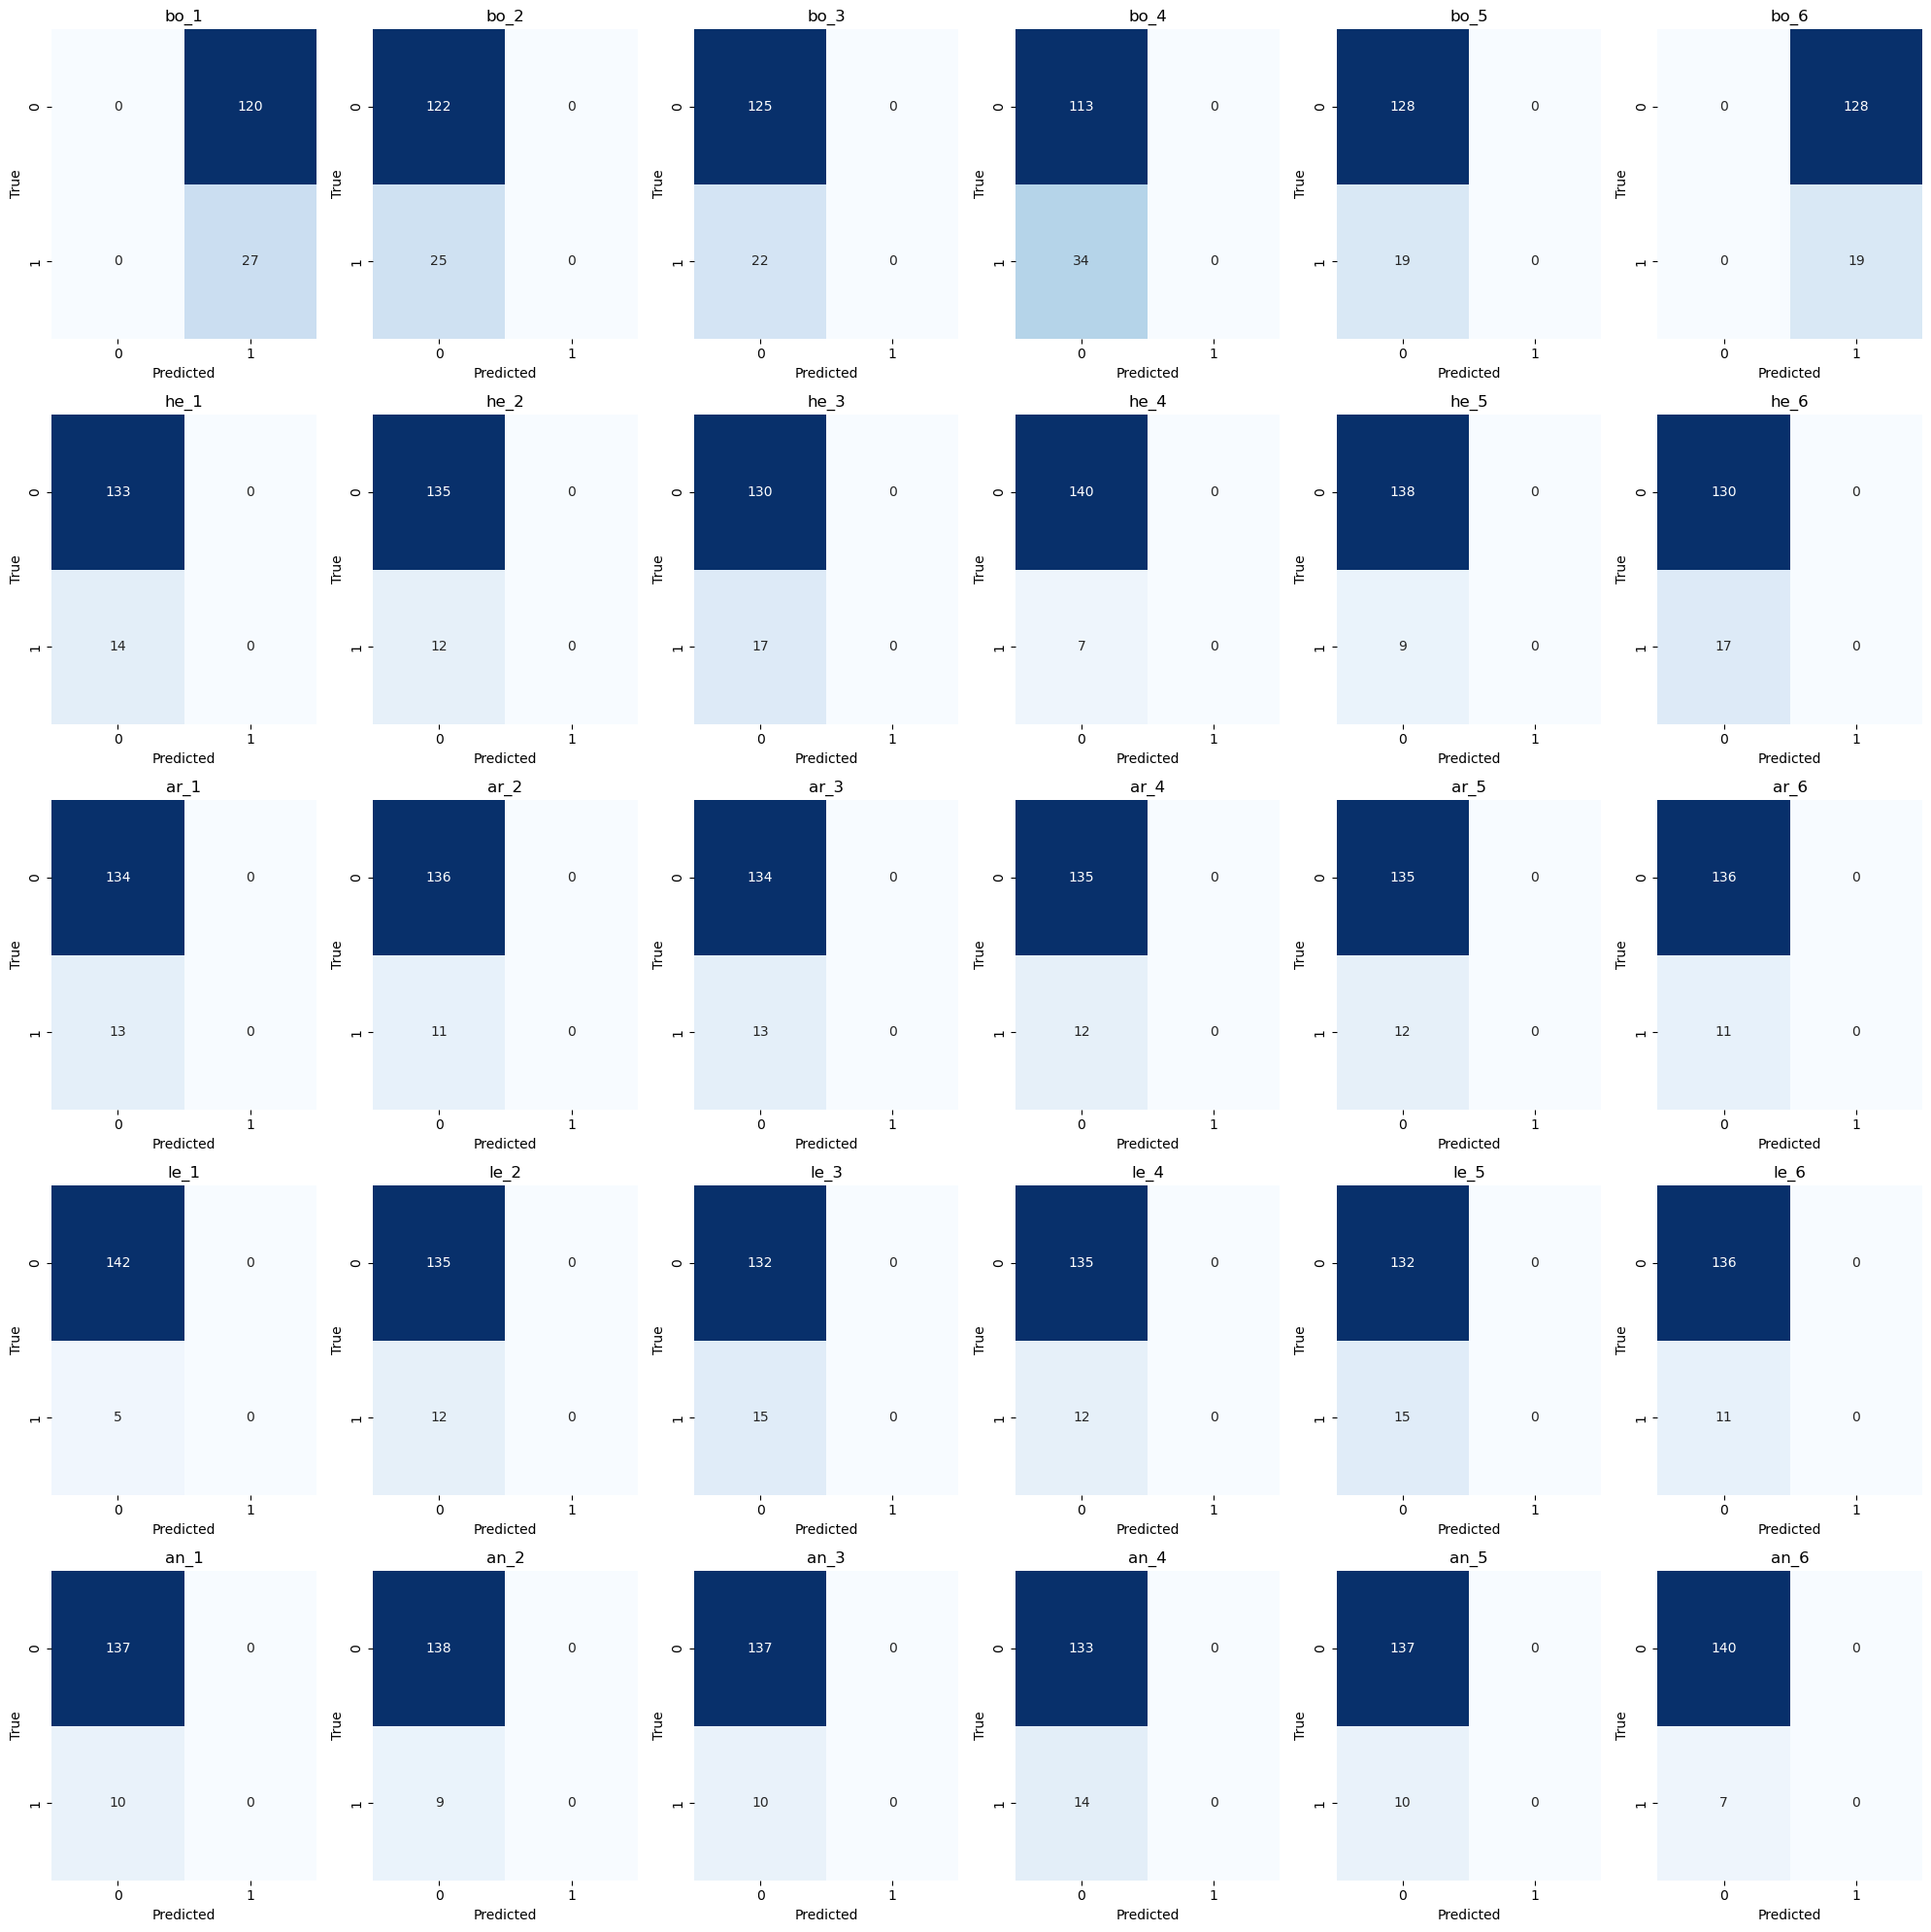

In [28]:
# Save model performance to a txt file
with open("Model Performance.txt", "w") as f:
    with contextlib.redirect_stdout(f):
        print("Fit the CNN model", file=f)
        print("---------------------------------------------------------------", 
              file=f)

        print("Fit on validation data", file=f)
        val_loss, val_recall, val_precision, val_accuracy = \
            model.evaluate(val_data)
        print(f"Validation data loss: {val_loss}", file=f)
        print(f"Validation data accuracy: {val_accuracy}", file=f)
        print(f"Validation data recall: {val_recall}", file=f)
        print(f"Validation data precision: {val_precision}", file=f)
        print("---------------------------------------------------------------", 
              file=f)

        print("Fit on testing data", file=f)
        test_loss, test_recall, test_precision, test_accuracy = \
            model.evaluate(test_data)
        print(f"Test data loss: {test_loss}", file=f)
        print(f"Test data accuracy: {test_accuracy}", file=f)
        print(f"Test data recall: {test_recall}", file=f)
        print(f"Test data precision: {test_precision}", file=f)
        print("---------------------------------------------------------------", 
              file=f)

        print("Use this model to predict labels from test_data images", file=f)
        predictions = model.predict(test_data)
        binary_prediction = np.where(predictions > p_r_threshold, 1, 0)
        _, _, true_labels = data_split(label_df, split_ratio, 
                                    random_state=random_state)
        print("---------------------------------------------------------------", 
              file=f)

        print("Evaluate the prediction", file=f)
        classifi_report, confusion_matrix, roc_auc = \
            test_predict_eval(binary_prediction, true_labels, feature_num, 
                            class_num, labels)

        print(classifi_report, file=f)
        print("---------------------------------------------------------------", 
              file=f)

# Save predicted and true labels for robots on testing data
binary_prediction = pd.DataFrame(binary_prediction, columns=labels)
predicted_labels_string = binary_prediction.apply(\
    lambda x: "_".join(list(np.array(binary_prediction.columns)[x == 1])), axis=1)
true_labels_string = true_labels.apply(\
    lambda x: "_".join(list(np.array(true_labels.columns)[x == 1])), axis=1)
testing_data_prediction = pd.DataFrame(list(zip(predicted_labels_string, 
                                                true_labels_string)),
                                       columns=["Predicted", "True"])
# Save DataFrame to a text file, using comma as the delimiter
testing_data_prediction.to_csv('testing_data_prediction.csv', index=False)


# Save and reload the model

In [29]:
model.save('test_model')

INFO:tensorflow:Assets written to: test_model/assets


INFO:tensorflow:Assets written to: test_model/assets


In [ ]:
# from tensorflow.keras.models import load_model
# model = load_model('saved_model/test_model')

# Questions